## channel capacity : theory, code, examples

This is all taken from
    * chapters 8 & 9 of MacKay's "Information Theory, Inference, and Learning Algorithms" 
    * chapter 5 of Biggs' "Codes : An Introduction to Information Communication and Cryptography".

Jim Mahoney | March 2017 | cs.marlboro.edu | MIT License

### theory ###

    X send --->  noise ---> Y receive

The situation is a communications channel, with X = ($x_1$, $x_2$, ...) the sent symbols and Y = ($y_1$, $y_2$, ...) the received symbols.  The channel itself is described by a conditional probability matrix P(Y|X) which gives the a probability of an $x_i$ becoming a $y_j$ due to noise.

    P(Y|X) =  P(Y=y1|X=x1)  P(Y=y1|X=x2) ...          a matrix
              P(Y=y2|X=x1)  P(Y=y2|X=x2) ...
              ...

In addition to these numbers, the probabilities P(X) are also needed to completely to specify the situation.

    P(X)   = P(X=x1)                                  a column vector
             P(X=x2)
             ...

Note that rows and columns of P(Y|X) as given here (with Y giving the row and X the column) are consistent with MacKay's formulation but are the transpose of Biggs' $\Gamma$ matrix.

The additional quantities we can calculate are then

    P(y,x) = joint probability = P(y|x) * P(x) , with the property that 1 = sum over x,y ( P(x,y) )
    P(y)   = sum over x ( P(y, x) ) = matrix(P(Y|X)) _matrix_multiply_ column(P(X)) , also sums to 1.
    H(Y,X) = - sum over x,y ( P(x,y) * log P(x,y) ) = the entropy (uncertainty) in the whole sysem
    H(X)   = - sum over x ( P(x) * log P(x) ) = entropy in X
    H(Y)   = - sum over y ( P(y) * log P(y) ) = entropy in Y

And with the relations suggested by this diagram :

    |---------------- H(X,Y) -------------------|
    |---- H(X) -------------------|
                   |-------- H(Y) --------------|
    |--- H(X|Y) ---|--- I(X;Y) ---|--- H(Y|X)---|

we can calculate from those

    I(X;Y) = H(X) + H(Y) - H(X,Y)
    H(X|Y) = H(X) - I(X;Y)
    H(Y|X) = H(Y) - I(X;Y)

Finally, if we allow P(X) to vary while keeping P(Y|X) fixed, the maximum value of I(X;Y) is C, the "channel capacity".

C is important since Shannon's "noisy-channel coding theorem" says that it's the maximum effective rate at which data can be sent over the channel, 

For example, if 2 two bit symbols (00, 11) are sent which due to noise turn into all 4 possibilities (00, 01, 10, 11), then the rate would be 2/4 = 0.5 

### code definitions

In [6]:
# using Python 3.5
# Jim's numerical plotting imports
from numpy import *                                                         
from matplotlib.pyplot import plot                                          
import matplotlib.pyplot as plt                                             
import numpy as np 

In [7]:
# We're going to start with P(Y|X) and P(X) in a matrix and array like this :
#
#   p_y_given_x = matrix( [[p(y1|x1), p(y1|x2), ...], [p(y2|x1), p(y2|x2, ...)], ... ]) # P(Y|X)
#   p_x = array([ p(x1), p(x2), p(x3), ...])                                            # P(X)
#
# and calculate everything from those.
#

def flatten(numbers):
    """ Given a matrix or sequence or other collection, 
        return a numpy 1D array of numbers. """
    return array(numbers).flatten()

def entropy(probabilities, weights=None):
    """ Return H = - sum( weights * log2(probabilities) )  .
        If weights=None then use weights=probabilities """
    # Both probabilities and weights must be collections
    # which can be flattened into numpy arrays of the same length.
    if weights == None:
        weights = probabilities
    return - sum( flatten(weights) * log2( flatten(probabilities) ))

def joint(p_y_given_x, p_x):
    """ Given a conditional probability matrix P(Y|X)  
        where Y is rows and and X is columns,
        and the probabilities P(X),
        return the joint probability matrix P(Y,X).
    """
    # print("joint DEBUG: p_y_given_x = ", p_y_given_x)
    # print("joint DEBUG: p_x = ", p_x)
    (n_y_rows, n_x_columns) = shape(p_y_given_x)
    # print("joint DEBUG n_y_rows, n_x_columns = ", n_y_rows, n_x_columns)
    assert len(p_x) == n_x_columns
    result = p_y_given_x.copy()
    for i in range(n_x_columns):   # multiply each p(Y| x_i) column by corresponding p(x_i)
        result[: , i] *= p_x[i]
    return result

def py(p_y_given_x, p_x):
    """ Find P(Y) given P(Y|X) and P(X)"""
    # Make P(X) a column vector then do matrix multiplication.
    (n_y, n_x) = shape(p_y_given_x)  # number of rows, columns of matrix
    column_vector_p_x = matrix(reshape(p_x, (n_x, 1)))
    return flatten(matrix(p_y_given_x) * column_vector_p_x)   # matrix multiplication

def analyze(p_y_given_x, p_x, verbose=False):
    """ Return I(X;Y). If verbose is True, print lots of channel parameters. """
    p_y_and_x = joint(p_y_given_x, p_x)
    p_y = py(p_y_given_x, p_x)
    H_x = entropy(p_x)
    H_y = entropy(p_y)
    H_xy = entropy(p_y_and_x)
    I_xy = H_x + H_y - H_xy
    H_x_given_y = H_x - I_xy
    H_y_given_x = H_y - I_xy
    if verbose:
        print(' --- channel analysis ---- (y=rows, x=columns)')
        print(' P(Y|X) = \n{}'.format(str(p_y_given_x)))
        print(' P(X) = {}'.format(str(p_x)))
        print(' sum P(x) = {}'.format(sum(flatten(p_x))))
        print(' ... ')
        print(' P(Y) = {}'.format(str(p_y)))
        print(' sum P(Y) = {}'.format(sum(flatten(p_y))))
        print(' P(X,Y) = \n{}'.format(str(p_y_and_x)))
        print(' sum P(X,Y) = {}'.format(sum(flatten(p_y_and_x))))
        print(' H(X) = {}, H(Y) = {}, H(X,Y) = {}'.format(H_x, H_y, H_xy))
        print(' H(X|Y) = {}, H(Y|X) = {}'.format(H_x_given_y, H_y_given_x))
        print(' I(X;Y) = {}'.format(I_xy))
    return I_xy
    

### symmetric binary channel

       P(y=0 | x=0) = 1 - f       P(y=0 | x=1) = f
       P(y=1 | x=0) = f           P(y=1 | x=1) = 1 - f

In [8]:
def symmetric_probabilities(f, px0=0.5):
    """ Return (p_x_given_y, p_x) """
    return( matrix([ [1 - f, f], [f, 1 - f]]) , array([px0, 1 - px0]) )

f = 0.1
sym_p = symmetric_probabilities(f)
analyze(sym_p[0], sym_p[1], verbose=True)

 --- channel analysis ---- (y=rows, x=columns)
 P(Y|X) = 
[[0.9 0.1]
 [0.1 0.9]]
 P(X) = [0.5 0.5]
 sum P(x) = 1.0
 ... 
 P(Y) = [0.5 0.5]
 sum P(Y) = 1.0
 P(X,Y) = 
[[0.45 0.05]
 [0.05 0.45]]
 sum P(X,Y) = 1.0
 H(X) = 1.0, H(Y) = 1.0, H(X,Y) = 1.4689955935892813
 H(X|Y) = 0.46899559358928133, H(Y|X) = 0.46899559358928133
 I(X;Y) = 0.5310044064107187


0.5310044064107187

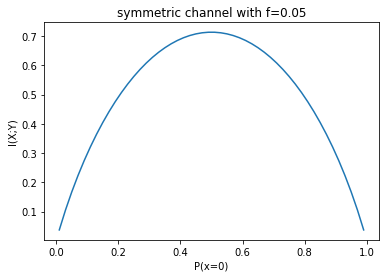

In [9]:
# Vary P(x=0) to see the maximum I, which is the channel capacity.

f = 0.05

px_sym_values = linspace(0.01, 0.99, num=50)
I_sym_values = array([ analyze(*symmetric_probabilities(f, px0)) for px0 in px_sym_values])

plt.figure()
plt.xlabel('P(x=0)')
plt.ylabel('I(X;Y)')
plt.title('symmetric channel with f={}'.format(f))
plot(px_sym_values, I_sym_values)
plt.show()                               

### MacKay's Z channel

       P(y=0 | x=0) = 1           P(y=0 | x=1) = f
       P(y=1 | x=0) = 0           P(y=1 | x=1) = 1 - f

In [10]:
def z_probabilities(f, px0=0.5):
    """ Return (p_x_given_y, p_x) """
    epsilon = 1e-5  # avoid divide by zero
    return( matrix([ [1-epsilon, epsilon], [f, 1.0 - f]]) , array([px0, 1 - px0]) )

f = 0.05
z_p = z_probabilities(f)
analyze(z_p[0], z_p[1], verbose=True)

 --- channel analysis ---- (y=rows, x=columns)
 P(Y|X) = 
[[9.9999e-01 1.0000e-05]
 [5.0000e-02 9.5000e-01]]
 P(X) = [0.5 0.5]
 sum P(x) = 1.0
 ... 
 P(Y) = [0.5 0.5]
 sum P(Y) = 1.0
 P(X,Y) = 
[[4.99995e-01 5.00000e-06]
 [2.50000e-02 4.75000e-01]]
 sum P(X,Y) = 1.0
 H(X) = 1.0, H(Y) = 1.0, H(X,Y) = 1.1432887401994871
 H(X|Y) = 0.14328874019948712, H(Y|X) = 0.14328874019948712
 I(X;Y) = 0.8567112598005129


0.8567112598005129

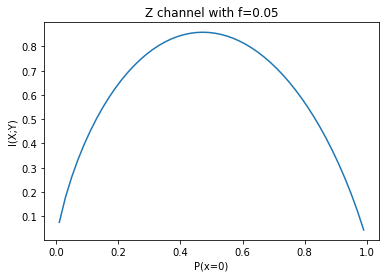

In [12]:
# Again, vary P(x=0) to see the maximum I which is the channel capacity.

f = 0.05

px_z_values = linspace(0.01, 0.99, num=50)
I_z_values = array([ analyze(*z_probabilities(f, px0)) for px0 in px_sym_values])

plt.figure()
plt.xlabel('P(x=0)')
plt.ylabel('I(X;Y)')
plt.title('Z channel with f={}'.format(f))
plot(px_z_values, I_z_values)
plt.show()                  

Notice that for the Z channel

    * The capacity is a bit larger than the symmetric channel, and
    
    * The capacity is not at P(x=0.5) but at a value which is a bit smaller.